# Plant Leaf Disease Detection
Mayur Kr. Garg

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model_utility import plot_images

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

### Data

In [3]:
BASE_DIR = "../../Datasets/New Plant Diseases (Augmented)"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

### Model

In [4]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 64
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

### Training

In [5]:
EPOCHS = 10

## Data Loading

### Data Distribution

#### Train

In [6]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Apple___Apple_scab                                 : 2016
Apple___Black_rot                                  : 1987
Apple___Cedar_apple_rust                           : 1760
Apple___healthy                                    : 2008
Blueberry___healthy                                : 1816
Cherry_(including_sour)___healthy                  : 1826
Cherry_(including_sour)___Powdery_mildew           : 1683
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 1642
Corn_(maize)___Common_rust_                        : 1907
Corn_(maize)___healthy                             : 1859
Corn_(maize)___Northern_Leaf_Blight                : 1908
Grape___Black_rot                                  : 1888
Grape___Esca_(Black_Measles)                       : 1920
Grape___healthy                                    : 1692
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 1722
Orange___Haunglongbing_(Citrus_greening)           : 2010
Peach___Bacterial_spot                             : 1838
Peach___health

#### Validation

In [7]:
total_val = 0

for d in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, d)
    img_count = len(os.listdir(path))
    total_val += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal validation images: {total_val}')

Apple___Apple_scab                                 : 504
Apple___Black_rot                                  : 497
Apple___Cedar_apple_rust                           : 440
Apple___healthy                                    : 502
Blueberry___healthy                                : 454
Cherry_(including_sour)___healthy                  : 456
Cherry_(including_sour)___Powdery_mildew           : 421
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 410
Corn_(maize)___Common_rust_                        : 477
Corn_(maize)___healthy                             : 465
Corn_(maize)___Northern_Leaf_Blight                : 477
Grape___Black_rot                                  : 472
Grape___Esca_(Black_Measles)                       : 480
Grape___healthy                                    : 423
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 430
Orange___Haunglongbing_(Citrus_greening)           : 503
Peach___Bacterial_spot                             : 459
Peach___healthy                

#### Test

In [8]:
total_test = len(os.listdir(TEST_DIR))

for i in os.listdir(TEST_DIR):
    print(i)

print(f'\nTotal testing images: {total_test}')

AppleCedarRust1.JPG
AppleCedarRust2.JPG
AppleCedarRust3.JPG
AppleCedarRust4.JPG
AppleScab1.JPG
AppleScab2.JPG
AppleScab3.JPG
CornCommonRust1.JPG
CornCommonRust2.JPG
CornCommonRust3.JPG
PotatoEarlyBlight1.JPG
PotatoEarlyBlight2.JPG
PotatoEarlyBlight3.JPG
PotatoEarlyBlight4.JPG
PotatoEarlyBlight5.JPG
PotatoHealthy1.JPG
PotatoHealthy2.JPG
TomatoEarlyBlight1.JPG
TomatoEarlyBlight2.JPG
TomatoEarlyBlight3.JPG
TomatoEarlyBlight4.JPG
TomatoEarlyBlight5.JPG
TomatoEarlyBlight6.JPG
TomatoHealthy1.JPG
TomatoHealthy2.JPG
TomatoHealthy3.JPG
TomatoHealthy4.JPG
TomatoYellowCurlVirus1.JPG
TomatoYellowCurlVirus2.JPG
TomatoYellowCurlVirus3.JPG
TomatoYellowCurlVirus4.JPG
TomatoYellowCurlVirus5.JPG
TomatoYellowCurlVirus6.JPG

Total testing images: 33


In [9]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


### Image Generators

#### Train

In [10]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 70295 images belonging to 38 classes.


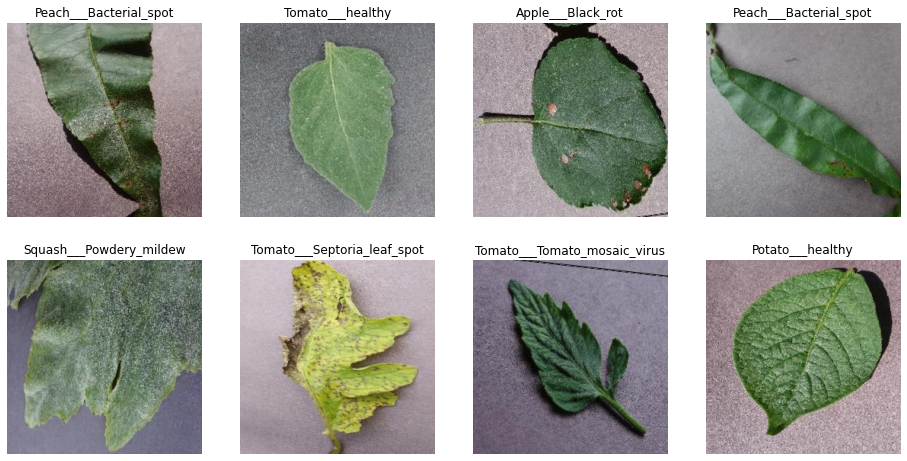

In [11]:
plot_images(train_data_gen)

#### Validation

In [12]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


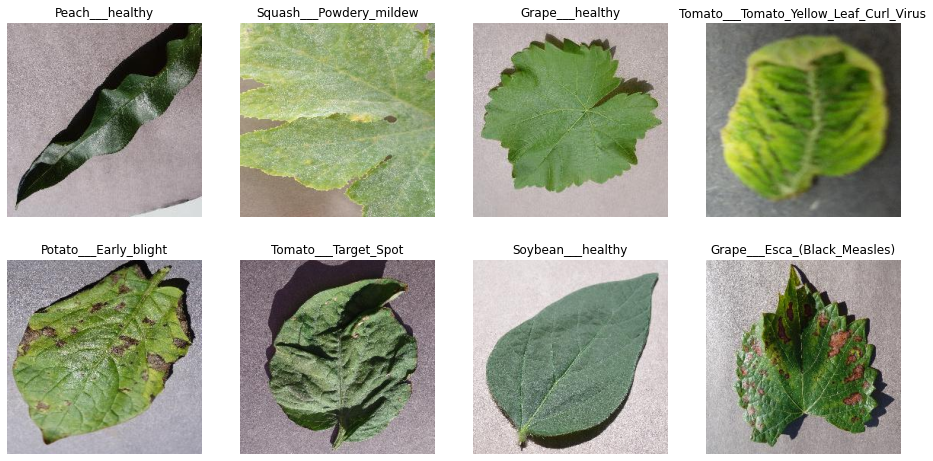

In [13]:
plot_images(val_data_gen)

## Model

### Input Layer

In [14]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

TensorShape([None, 256, 256, 3])

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [15]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

TensorShape([None, 256, 256, 24])

In [16]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

TensorShape([None, 256, 256, 64])

In [17]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

TensorShape([None, 128, 128, 64])

#### Block 2

In [18]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

TensorShape([None, 128, 128, 64])

In [19]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

TensorShape([None, 128, 128, 128])

In [20]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

TensorShape([None, 64, 64, 128])

#### Block 3

In [21]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

TensorShape([None, 64, 64, 128])

In [22]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

TensorShape([None, 64, 64, 256])

In [23]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

TensorShape([None, 32, 32, 256])

#### Block 4

In [24]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

TensorShape([None, 32, 32, 256])

In [25]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

TensorShape([None, 32, 32, 512])

In [26]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

TensorShape([None, 16, 16, 512])

#### Block 5

In [27]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

TensorShape([None, 16, 16, 512])

In [28]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

TensorShape([None, 16, 16, 1024])

In [29]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

TensorShape([None, 8, 8, 1024])

### Global Average Pooling layers for each block

In [30]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

TensorShape([None, 64])

In [31]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

TensorShape([None, 128])

In [32]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

TensorShape([None, 256])

In [33]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

TensorShape([None, 512])

In [34]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

TensorShape([None, 1024])

### Concatenation Layer

In [35]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

TensorShape([None, 1984])

### Dropout and Dense Layers

In [36]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

TensorShape([None, 1984])

In [37]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

TensorShape([None, 512])

In [38]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

TensorShape([None, 512])

In [39]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

TensorShape([None, 38])

### Model Summary

In [40]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
model.summary()

Model: "Plant_Leaf"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
DwC_1 (DepthwiseConv2D)         (None, 256, 256, 24) 120         Input[0][0]                      
__________________________________________________________________________________________________
PwC_1 (Conv2D)                  (None, 256, 256, 64) 1600        DwC_1[0][0]                      
__________________________________________________________________________________________________
MP_1 (MaxPooling2D)             (None, 128, 128, 64) 0           PwC_1[0][0]                      
_________________________________________________________________________________________

In [ ]:
history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
)